# 主成分分析

*PCA: Principal Component Analysis*

次元削減を行う最も基本的な手法。

主成分分析では、データ空間$\R^l$内に$m$（$m\leq l$）個の互いに直行する軸を設定し、この軸にデータを射影することで次元を削減する。軸は射影後のデータの分散が最も大きくなるように定義する。  
なおこの軸は**主成分軸**と呼ぶ。射影されたデータは**主成分得点**と呼ぶ。

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

図で説明する。コードは関係ないので見ないで。

こんな2次元のデータがあったとする。

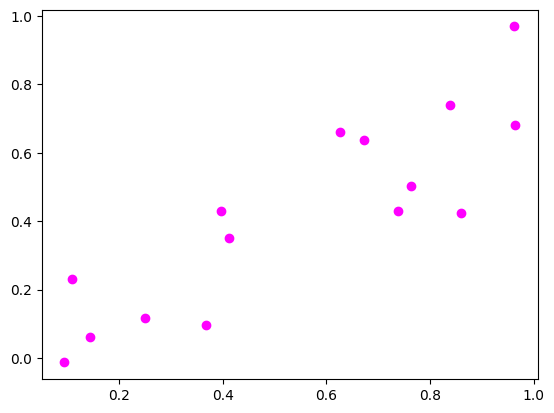

In [2]:
n = 15
a = 3/4
x1 = np.random.random(n)
x2 = a * x1
x2 += 0.1 * np.random.randn(n)
plt.scatter(x1, x2, color='magenta');

主成分軸を求める

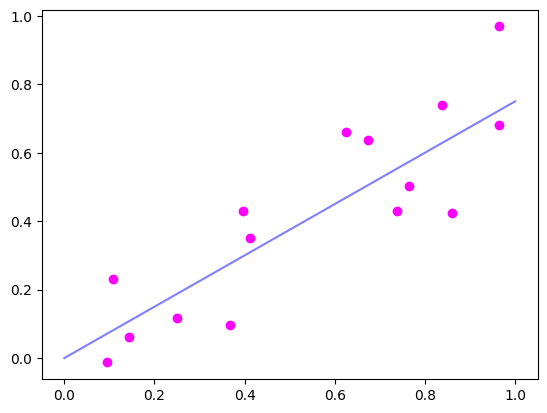

In [3]:
plt.plot([0, 1], [0, a], color='blue', alpha=0.5);
plt.scatter(x1, x2, color='magenta');

この軸にデータを射影して、次元を削減する。

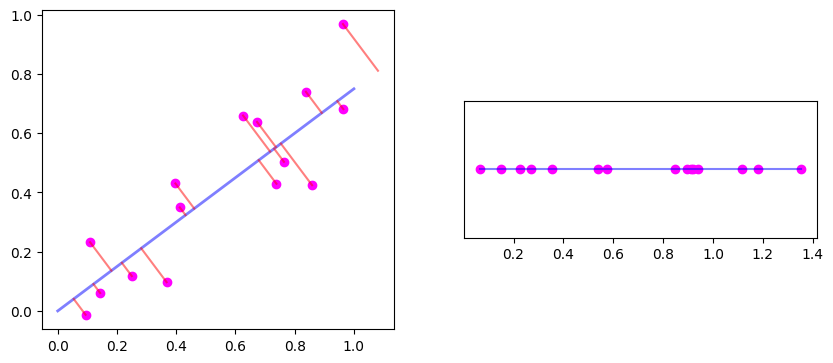

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_aspect('equal')
ax2.set_yticks([])
ax2.set_aspect(5)

x = np.array([0, 1])
y = x * 3/4
ax1.plot(x, y, color='blue', linewidth=2, alpha=0.5);

p1 = (x2 + x1/a) / (a + 1/a)
p2 = a * p1
pc = (p1**2 + p2**2)**0.5

for i in range(n):
    ax1.plot([x1[i], p1[i]], [x2[i], p2[i]], color='red', alpha=0.5)
ax1.scatter(x1, x2, color='magenta');

ax2.plot([pc.min(), pc.max()], [0, 0], color='blue', alpha=0.5)
ax2.scatter(pc, np.zeros_like(pc), color='magenta');


---

## 分散の最大化

主成分分析では主成分軸と呼ばれる軸を求めるが、その軸は射影後の分散が最大化になるように求める。

分散を最大化する目的について、納得のいく記述が少ない。データの違いが表れるように、とかがよく言われるけど、なんかしっくりこない。

ということで、分散を最大化する目的について、自分なりに考えてみた。そして、自分ではとても納得のいく説明が出来た。それをまとめる。

基礎となる考え方は、「多くの情報を残したい」である。  
次元を減らすことで、当然元のデータからいくらかの情報が失われることとなる。この失われる情報を最小にしたいという願い。

少し表現を変えて、次元削減したデータが多くの情報を持つようにしたい、とする。  
ここで、確率分布が持つ情報量について記述したとある理論を用いる。

### 情報理論

1950年頃にクロード・シャノンによって提唱された。確率変数や確率分布が持つ情報量を記述した理論。  
機械学習とも密接な関わりがあり、個人的には結構好きな分野。

情報理論では、確率分布$p(x)$が持つ情報量$H(p)$を以下のように定義する。

$$
H(p) = -\sum_x p(x)\log p(x)
$$

これは情報エントロピーと言ったりする。この式の意味はここでは理解しなくてよい。何となく載せただけ。

情報エントロピーは確率分布が持つ情報量を示す。また、それと同時に「予測のしにくさ」を表すともいわれている。  
つまりこの理論によると、予測がしにくいほど情報量が多いということになる。

実際に見てみよう。二つの正規分布を考える。

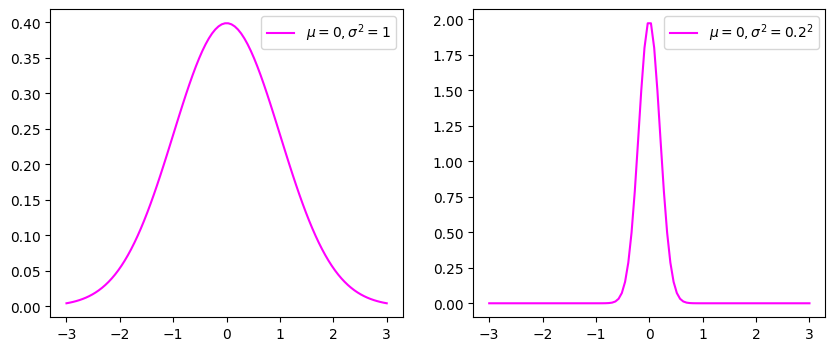

In [5]:
x = np.linspace(-3, 3, 100)
n1 = stats.norm.pdf(x, loc=0, scale=1)
n2 = stats.norm.pdf(x, loc=0, scale=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(x, n1, label=r'$\mu=0, \sigma^2=1$', color='magenta')
ax1.legend()
ax2.plot(x, n2, label=r'$\mu=0, \sigma^2=0.2^2$', color='magenta')
ax2.legend();

左は分散$\sigma^2=1$、右は$\sigma^2=0.2^2$。  
グラフを見ると、左の方が予測がしにくそうだ。広く分布しているから。

情報エントロピーを見てみよう。  
正規分布の情報エントロピーは以下になる。

参考: [正規分布のエントロピーの導出 - Mooの技術メモ](https://moo-tech.hatenablog.com/entry/2021/11/11/203000)

$$
H = \frac{1}{2}\big(\log(2\pi\sigma^2) + 1\big)
$$

分散に対して単調増加なので、分散が大きい左の分布の方が情報エントロピーが大きい=多くの情報量を持つということになる。

In [6]:
H = lambda sigma: 1/2 * (np.log(2*np.pi*sigma**2) + 1)
print('左の情報エントロピー', H(1))
print('右の情報エントロピー', H(0.2))

左の情報エントロピー 1.4189385332046727
右の情報エントロピー -0.1904993792294276


以上より、分散が大きい分布は多くの情報量を持つことが分かった。  

ここから、主成分分析の目的が射影後の分散の最大化であることが納得できる。  
射影後に多くの情報が残るようにしたいから、分散を最大化する。


---

## 主成分軸の導出

では、目標を理解したところで、それを達成する軸=主成分軸を求めていこう。

$$
\newcommand{\b}[1]{\boldsymbol #1}
$$

求める軸を$\b u_1$とする。これは$l$次元の単位ベクトル。  
ここで、データを平均0に中心化した場合、$\b u_1$にデータ$\b x_i$を射影した時の偏差は内積$\b u_1^T\b x_i$で表せる。つまり、$\b x_i$を全て$\b u_1$に射影した時の分散は以下となる。


$$
\begin{align}
J(\b u_1)
&= \frac{1}{N}\sum_n(\b u_1^T\b x_n)^2 \\
&= \frac{1}{N}\sum_n(\b u_1^T\b x_n)(\b u_1^T\b x_n) \\
&= \frac{1}{N}\sum_n(\b u_1^T\b x_n)(\b x_n^T\b u_1) \\
&= \b u_1^T\left(\frac{1}{N}\sum_n\b x_n\b x_n^T\right)\b u_1 \\
&=\b u_1^T\Sigma\b u_1 \\
\end{align}
$$

なお$\Sigma$は以下。

$$
\Sigma := \frac{1}{N}\sum_n\b x_n\b x_n^T
$$

これは中心化したデータの共分散行列となる。  
ただ共分散行列はデータの平均に依らないので、データの共分散行列と一緒。

以上を踏まえると、求めたい$\b u_1$は以下となる。

$$
\b u_1 = \argmax_{\b u}J(\b u) = \argmax_{\b u}\b u^T\Sigma\b u
$$

また、以下の制約条件も同時に課される。

$$
\b u^T\b u = 1
$$

これは$\b u$が単位ベクトルであることを示している。  
この条件がない場合、ただ分散=内積を大きくすれば良くなり、方向を無視した無限の大きさを持つベクトルが解となってしまう。

以上より、解くべき問題を条件付き最適化問題に落とし込むことが出来た。これをラグランジュの未定乗数法で解く。  
まずラグランジュ関数を定義する。

$$
L(\b u, \lambda) = \b u^T\Sigma\b u - \lambda(\b u^T\b u-1)
$$

これを$\b u$で偏微分し、0になる$\b u$を求める。

$$
\frac{\partial L}{\partial \b u} = 2\Sigma\b u - 2\lambda \b u = 0 \\
\Sigma\b u = \lambda\b u
$$

ここで、$\Sigma$は正方行列、$\lambda$はスカラーであるため、これを満たす$\b u$は$\Sigma$の固有ベクトルとなる。また両辺に$\b u^T$をかけると、制約条件より

$$
\b u^T\Sigma\b u = \b u^T\lambda\b u = \lambda
$$

が成り立ち、これは固有値$\lambda$が最大化したい射影後の分散と一致することを表している。

よって、分散を最大化する$\b u$は$\Sigma$の最大固有値に対応する固有ベクトルとなる。

次に2番目以降の主成分$\b u_2, \b u_3, \cdots, \b u_m$を求めたいのだが、$S$の固有値が大きい順に対応する固有ベクトルを並べればそれで終わりである。残っている固有ベクトルの中で分散が最も大きくなるものを選び続ける、というイメージ。  
また、主成分同士が直行することも満たすべき条件であるが、$\Sigma$が対称行列であるため固有ベクトル同士が直行し、条件を満たす。

### Iris Dataset

実際に主成分分析を行って次元削減をしてみる。  
Irisデータセットを用いる。

In [7]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris.data
X = StandardScaler().fit_transform(X) # 正規化
X = X.T # (特徴量の数l, サンプル数N) としたいので転置
y = iris.target
l, N = X.shape
print('num of features:', l)
print('num of data:', N)

num of features: 4
num of data: 150


主成分軸を求める。

In [8]:
cov_mat = np.cov(X) # 共分散行列
pc_val, pc_vec = np.linalg.eig(cov_mat) # 固有値分解
for l, u in zip(pc_val, pc_vec.T):
    print('固有値:', round(l, 4), '| 固有ベクトル:', u)

固有値: 2.9381 | 固有ベクトル: [ 0.52106591 -0.26934744  0.5804131   0.56485654]
固有値: 0.9202 | 固有ベクトル: [-0.37741762 -0.92329566 -0.02449161 -0.06694199]
固有値: 0.1477 | 固有ベクトル: [-0.71956635  0.24438178  0.14212637  0.63427274]
固有値: 0.0209 | 固有ベクトル: [ 0.26128628 -0.12350962 -0.80144925  0.52359713]


固有値の大きい2つの固有ベクトルにデータを射影し、2次元に削減する。

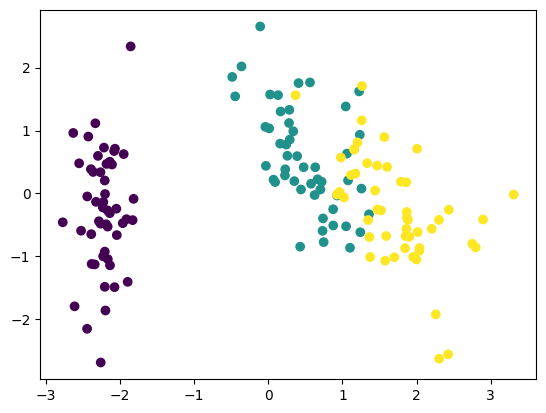

In [9]:
m = 2
pc = X.T @ pc_vec[:, :m] # 射影
plt.scatter(pc[:, 0], pc[:, 1], c=y);

2次元に削減したことで可視化が可能になった。  
クラスごとに特徴が表れていることがよく分かる。


---

## 特異値分解

主成分分析と特異値分解は深い関わりがある。

行列$X\in\R^{l\times n}$は特異値分解によって以下のように記述できる。

$$
X=UDV^T
$$

- $U\in\R^{l\times r}$: $XX^T$の固有ベクトルを一行に並べたもの
- $V\in\R^{N\times r}$: $X^TX$の固有ベクトルを一行に並べたもの
- $D\in\R^{r\times r}$: 特異値$\sigma_i=\sqrt{\lambda_i},\,i=1,2,\cdots,\,r$を対角成分に持つ対角行列

$D$は$\Sigma$と表記することが多いが、共分散行列と紛らわしいので、ここでは$D$とする。

$X\in\R^{l\times N}$をデータセットと見る。データベクトル$\boldsymbol x_n\in\R^l,n=1,2,\cdots,N$を一行に並べたもの。

$$
X=[\b x_1,\b x_2,\cdots,\b x_N]
$$

こうすると、$XX^T$は$X$の共分散行列に$N$を掛けたものとなる。そして、固有ベクトルはスカラーを掛けても変わらない。$X$の共分散行列も、それに$N$を掛けた$XX^T$も同じ固有ベクトルを持つ。  
つまり、$X$の特異値分解によって得られる$U=[\b u_1,\b u_2,\cdots,\b u_m]$は、$X$の主成分分析によって得られる主成分軸と同じものである。


やってみよう

In [10]:
U, s, Vh = np.linalg.svd(X) # 特異値分解
U

array([[-0.52106591, -0.37741762,  0.71956635,  0.26128628],
       [ 0.26934744, -0.92329566, -0.24438178, -0.12350962],
       [-0.5804131 , -0.02449161, -0.14212637, -0.80144925],
       [-0.56485654, -0.06694199, -0.63427274,  0.52359713]])

さっき求めた主成分軸と比較

In [11]:
pc_vec

array([[ 0.52106591, -0.37741762, -0.71956635,  0.26128628],
       [-0.26934744, -0.92329566,  0.24438178, -0.12350962],
       [ 0.5804131 , -0.02449161,  0.14212637, -0.80144925],
       [ 0.56485654, -0.06694199,  0.63427274,  0.52359713]])

よく見ると一部の要素の正負が逆になっている。  
これは主成分軸の向きが逆になっていることを意味している。分散を最大化すると言う主成分軸としての役割はちゃんと持っている。

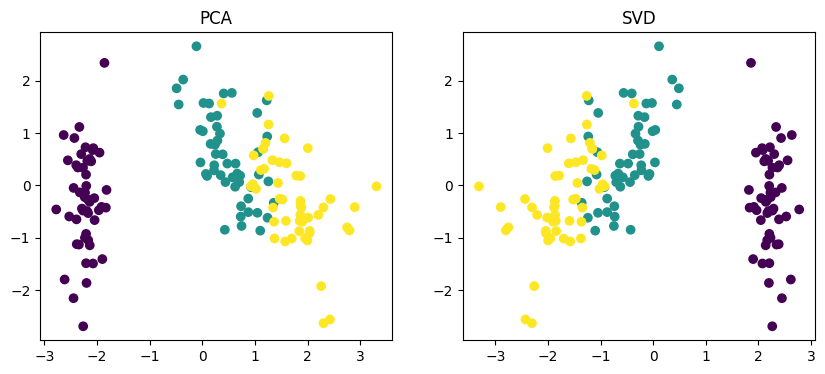

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
m = 2
pc_pca = X.T @ pc_vec[:, :m] # 主成分分析
pc_svd = X.T @ U[:, :m] # 特異値分解
ax1.scatter(pc_pca[:, 0], pc_pca[:, 1], c=y);
ax1.set_title('PCA')
ax2.scatter(pc_svd[:, 0], pc_svd[:, 1], c=y);
ax2.set_title('SVD');

軸が逆になっているので、射影したデータも反転する。


---

## 主成分得点

射影後のデータ。主成分と呼ぶこともある気がする。  
潜在変数と扱うこともできる。潜在変数はデータをよく表した観測できない変数のこと。

主成分得点はそれぞれ無相関である。  
相関のある方向に軸を設定するので、直感的になんとなく納得する。

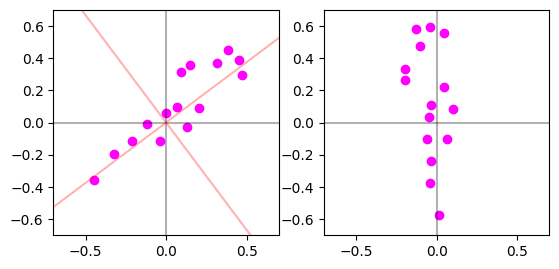

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)

lim = [-0.7, 0.7]
for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, [0, 0], color='black', alpha=0.3)
    ax.plot([0, 0], lim, color='black', alpha=0.3)

n = 15
a = 3/4
x1 = np.random.random(n) - 0.5
x2 = a * x1
x2 += 0.1 * np.random.randn(n)

p1 = (x2 + x1/a) / (a + 1/a)
p2 = a * p1
pc1 = (p1**2 + p2**2)**0.5 * np.sign(p1)

a_orth = -1/a
p1 = (x2 + x1/a_orth) / (a_orth + 1/a_orth)
p2 = a_orth * p1
pc2 = (p1**2 + p2**2)**0.5 * np.sign(p1)

x = np.array(lim)
ax1.plot(x, a*x, color='red', alpha=0.3)
ax1.plot(x, a_orth*x, color='red', alpha=0.3);
ax1.scatter(x1, x2, color='magenta')
ax2.scatter(pc2, pc1, color='magenta');

数学的な証明は一旦省略


---

## 主成分軸の解釈

主成分軸は$𝑙$次元ベクトルである。  
今まではこれを「基底」として見てきたが、$\R^l$に存在する一つの「データ」と見ることもできる。そのデータはどんなものだろうか。

画像を例に考える。ピクセルごとの色が記述された一般的なデータ形式とする。  
標準基底の場合、基底となっているデータは、どこか一つのピクセルのみに色がついた画像と見做せる。

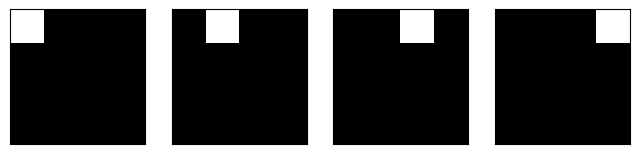

In [14]:
s = 4
I = np.eye(s**2)
fig, axes = plt.subplots(1, s, figsize=(8, 2))
for e, ax in zip(I[:s], axes):
    ax.imshow(e.reshape(s, s), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

では、主成分軸はどのようなデータになっているだろう。

主成分軸は、それがどれだけ含まれているかを表すことでそのデータの大体を記述できるような軸となっている。  
そのため、軸そのものがある程度の意味を持ったものであることが予想できる。↑のような訳分からん画像にはならんだろう。

実際に、適当な画像データセットでやってみよう。  
以下の様な画像データを使う。

In [15]:
from sklearn.datasets import fetch_lfw_people
ds = fetch_lfw_people(min_faces_per_person=10)

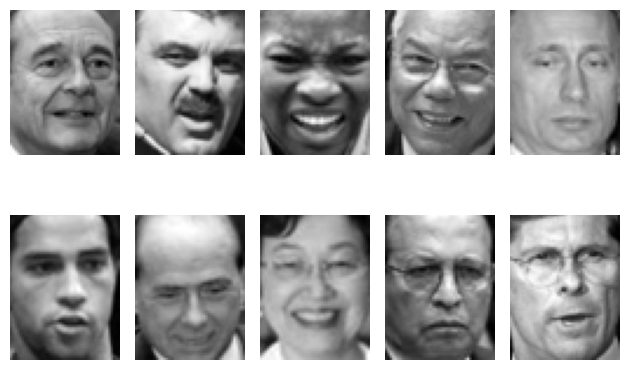

In [16]:
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(ds.images[i], cmap='gray')
    ax.axis('off')
plt.tight_layout();

各画像は$h\times w$の2次元のデータである。  
これを1次元に変換したベクトル$\b x_n\in\R^l,\,l=h\cdot w$を一つのデータとし、さらにそれを1行に並べた行列$X\in\R^{l\times N}$をデータセットとする。

$X$の主成分分析を行い、主成分軸を可視化するとこうなる。

In [17]:
X = ds.data.T
n_samples, w, h = ds.images.shape
cov_mat = np.cov(X)
pc_val, pc_vec = np.linalg.eig(cov_mat) # 主成分分析

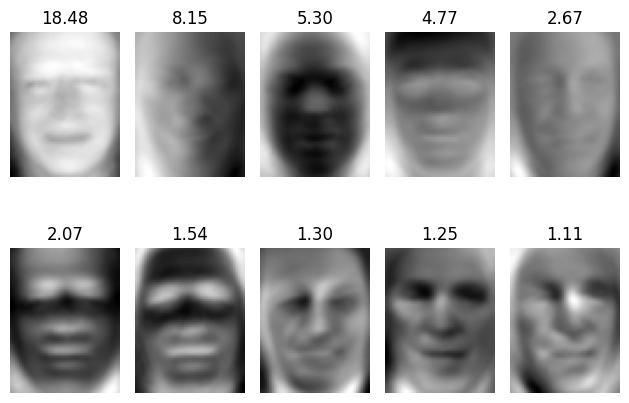

In [18]:
fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.ravel()):
    pc_img = pc_vec[:, i].reshape(w, h)
    ax.imshow(pc_img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{pc_val[i]:.2f}')
plt.tight_layout();

対応する固有値の大きい順に10個載せた。画像の場合は固有画像とも呼ぶ。さらに顔画像の場合は固有顔とも呼ぶ。  
このように軸をよく観察すると、元のデータがどのように構成されているかがわかりやすくなるね。

再構成してみる。

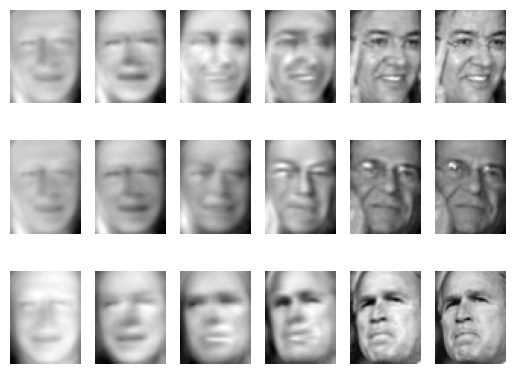

In [19]:
n_examples = 3
ns = np.random.choice(n_samples, n_examples)
ms = [5, 10, 30, 100, 500]
fig, axes = plt.subplots(n_examples, len(ms) + 1)
for n, axes_row in zip(ns, axes):
    img_org = ds.data[n]
    for m, ax in zip(ms, axes_row):
        pc = pc_vec[:, :m]
        img_rec = pc @ pc.T @ img_org
        img_rec = img_rec.reshape(w, h)
        ax.imshow(img_rec, cmap='gray')
        ax.axis('off')
    ax = axes_row[-1]
    ax.imshow(ds.images[n], cmap='gray')
    ax.axis('off')

左からm = [5, 10, 30, 100, 500]。一番右が元の画像。  
主成分を多く使うほどよく近似できることがわかる。